# Project: Banana Navigation

## Select Device Type

In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
device

device(type='cuda', index=0)

## Create UnityEnvironment
Create Unity Environment If you have a Linux environment, create an environment without a screen.

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import platform

if platform.system() == 'Linux':
    env = UnityEnvironment(file_name="./Banana_Linux_NoVis/Banana.x86_64")
elif platform.system() == 'Darwin':
    env = UnityEnvironment(file_name="Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

brain_name, brain

('BananaBrain', <unityagents.brain.BrainParameters at 0x7f1c791d99e8>)

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


## Implementation DQN

Execute learning or agent according to DQN algorithm. Run basic DQN or Dueling DQN by `agent` value
If the average score exceeds 13, the network weight value is stored in torch.save.

In [5]:
from collections import deque
import torch

def dqn(agent, 
        n_episodes=4000, max_t=1000, 
        eps_start=1.0, eps_end=0.01, eps_decay=0.999, 
        train=True, checkpoint_filename='checkpoint.pth'):
    """Deep Q-Learning.
    
    Args
        agent (str): agent type
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        train (bool): flag deciding if the agent will train or just play through the episode
        checkpoint_filename (str): filename of checkpoint
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        
        for t in range(max_t):
            action = agent.act(state, eps if train else 0.0)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            if train:
                agent.step(state, action, reward, next_state, done)
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                break
        
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            
        if np.mean(scores_window) >= 13.0 and train:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(
                i_episode-100, 
                np.mean(scores_window)
            ))
            torch.save(agent.qnetwork_local.state_dict(), checkpoint_filename)
            break
            
    return scores

## Train agent with Basic DQN

In [8]:
from agent import Agent
from model import *
qnet_agent = Agent(network_type=QNetwork.net_type,
                  state_size=state_size, 
                  action_size=action_size, 
                  seed=0,
                  device=device)
qnet_scores = dqn(qnet_agent, n_episodes=4000, train=True, checkpoint_filename='qnetwork_checkpoint.pth')

Episode 100	Average Score: 0.18
Episode 200	Average Score: 0.50
Episode 300	Average Score: 1.42
Episode 400	Average Score: 2.33
Episode 500	Average Score: 3.19
Episode 600	Average Score: 4.05
Episode 700	Average Score: 5.60
Episode 800	Average Score: 6.35
Episode 900	Average Score: 7.29
Episode 1000	Average Score: 8.16
Episode 1100	Average Score: 8.58
Episode 1400	Average Score: 9.642
Episode 1500	Average Score: 10.49
Episode 1600	Average Score: 10.17
Episode 1700	Average Score: 11.01
Episode 1800	Average Score: 11.11
Episode 1900	Average Score: 11.04
Episode 2000	Average Score: 10.78
Episode 2100	Average Score: 11.11
Episode 2200	Average Score: 12.78
Episode 2300	Average Score: 12.28
Episode 2400	Average Score: 12.60
Episode 2438	Average Score: 13.01
Environment solved in 2338 episodes!	Average Score: 13.01


## Train agent with Dueling DQN

In [6]:
from agent import Agent
from model import *
duel_agent = Agent(network_type=DuelingQNetwork.net_type,
                  state_size=state_size, 
                  action_size=action_size, 
                  seed=0,
                  device=device)
duel_scores = dqn(duel_agent, n_episodes=4000, train=True, checkpoint_filename='duel_checkpoint.pth')

Episode 100	Average Score: -0.01
Episode 200	Average Score: 0.591
Episode 300	Average Score: 1.29
Episode 400	Average Score: 1.72
Episode 500	Average Score: 2.65
Episode 600	Average Score: 4.27
Episode 700	Average Score: 5.37
Episode 800	Average Score: 6.06
Episode 900	Average Score: 6.46
Episode 1000	Average Score: 7.73
Episode 1100	Average Score: 7.74
Episode 1200	Average Score: 7.95
Episode 1300	Average Score: 9.32
Episode 1400	Average Score: 9.930
Episode 1500	Average Score: 10.76
Episode 1600	Average Score: 12.05
Episode 1700	Average Score: 10.76
Episode 1800	Average Score: 11.27
Episode 1900	Average Score: 11.63
Episode 2000	Average Score: 11.86
Episode 2100	Average Score: 12.63
Episode 2200	Average Score: 12.97
Episode 2204	Average Score: 13.02
Environment solved in 2104 episodes!	Average Score: 13.02


<IPython.core.display.Javascript object>


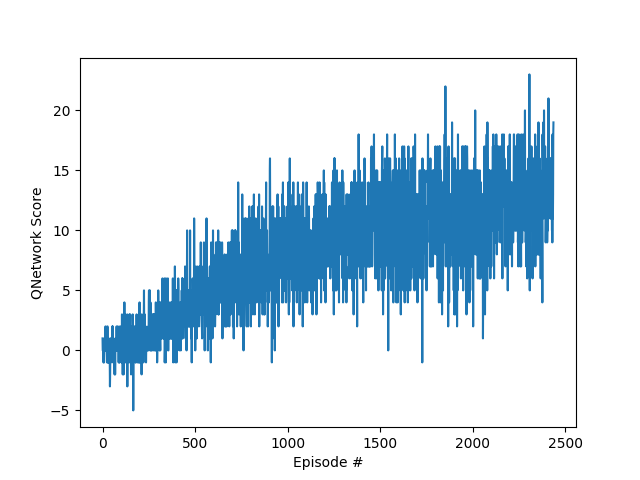

In [13]:
import matplotlib.pyplot as plt
%matplotlib notebook

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(qnet_scores)), qnet_scores)
plt.ylabel('QNetwork Score')
plt.xlabel('Episode #')
plt.show()

<IPython.core.display.Javascript object>


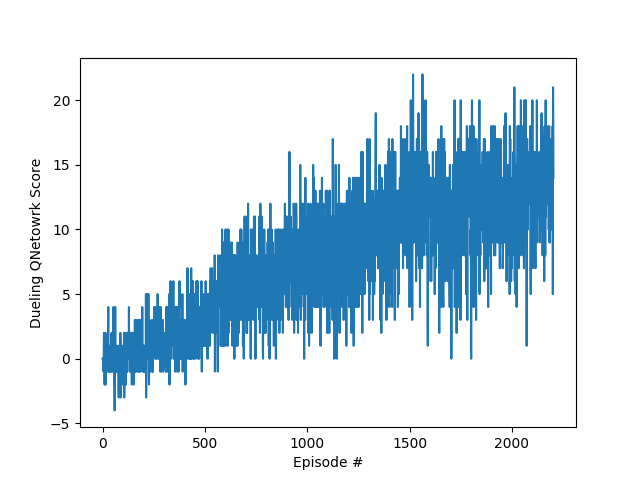

In [14]:
import matplotlib.pyplot as plt
%matplotlib notebook

# plot the dueling network scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(duel_scores)), duel_scores)
plt.ylabel('Dueling QNetowrk Score')
plt.xlabel('Episode #')
plt.show()

## Run Trained Agent

In [11]:
from agent import Agent
from model import *
agent = Agent(network_type=QNetwork.net_type,
              state_size=state_size,
              action_size=action_size, 
              seed=0,
              device=device,
              checkpoint_filename='qnetwork_checkpoint.pth')

scores = dqn(agent, n_episodes=100, train=False)

Episode 100	Average Score: 14.29


## Close environment

In [ ]:
env.close()